In [46]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, max_error
import random
import numpy as np

In [47]:
mbd = pd.read_csv("MBD_CFIP_20monthlag.csv")

# Dropping rows from CFIPS #28055 which contains values of 0, in order to calculate SMAPE
mbd = mbd.drop(mbd[mbd["CFIP"]==28055].index)
mbd = mbd.to_numpy()

In [48]:
# train/test split
X = mbd[:,2:-1]
y = mbd[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# SMAPE method for evaluation
def smape(y_test, y_pred):
    numerator = np.abs(y_test-y_pred)
    denominator = (y_test + np.abs(y_pred)) /200
    return np.mean(np.divide(numerator,denominator))

In [50]:
# baseline with no model. predictions made by averaging the predictors

y_pred = []
for obs in X_test:
    pred = np.mean(obs)
    y_pred.append(pred)

print("SMAPE: %.8f" % smape(y_test, y_pred))

SMAPE: 6.61455788


In [51]:
# linear regression
regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.8f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.8f" % r2_score(y_test, y_pred))
# The SMAPE
print("SMAPE: %.8f" % smape(y_test, y_pred))

Coefficients: 
 [-8.11233736e-03  7.82530741e-04  1.45637591e-02  8.55830140e-01
 -8.23285392e-01 -2.33825041e-03  1.04753178e-02 -8.91073783e-02
  3.31735126e-02 -1.09070745e-03  1.53199216e-02 -2.39708676e-02
 -3.50060223e-02  2.55126897e-02 -2.86659450e-03  3.03596329e-02
 -7.18634911e-02  1.04116097e-01 -1.47989350e-02  9.88816403e-01]
Mean squared error: 0.13935522
Coefficient of determination: 0.99646098
SMAPE: 2.79810986


In [52]:
# ridge regression

clf = Ridge(alpha=0.5)
clf.fit(X_train, y_train)
y_pred_ridge = clf.predict(X_test)

print("Coefficients: \n", clf.coef_)
# The mean squared error
print("Mean squared error: %.8f" % mean_squared_error(y_test, y_pred_ridge))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.8f" % r2_score(y_test, y_pred_ridge))
# The SMAPE
print("SMAPE: %.8f" % smape(y_test, y_pred_ridge))

Coefficients: 
 [-8.11337363e-03  7.87818356e-04  1.45714952e-02  8.55793367e-01
 -8.23231349e-01 -2.36527309e-03  1.04714505e-02 -8.91040409e-02
  3.31684425e-02 -1.08752674e-03  1.53188600e-02 -2.39717366e-02
 -3.50038611e-02  2.55091377e-02 -2.86326635e-03  3.03566472e-02
 -7.18598380e-02  1.04116470e-01 -1.47794479e-02  9.88795484e-01]
Mean squared error: 0.13936157
Coefficient of determination: 0.99646082
SMAPE: 2.79806053


In [53]:
# kernel

kern = KernelRidge(alpha=0.5)
kern.fit(X_train, y_train)
y_pred_kernel = kern.predict(X_test)


# The mean squared error
print("Mean squared error: %.8f" % mean_squared_error(y_test, y_pred_kernel))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.8f" % r2_score(y_test, y_pred_kernel))
# The SMAPE
print("SMAPE: %.8f" % smape(y_test, y_pred_kernel))

Mean squared error: 0.13945667
Coefficient of determination: 0.99645840
SMAPE: 2.77427250


In [54]:
# gradient boosting regressor

gbr = GradientBoostingRegressor()
gbr.fit(X_train,y_train)
y_pred_gbr = gbr.predict(X_test)

# The SMAPE
print("SMAPE: %.8f" % smape(y_test, y_pred_gbr))

SMAPE: 2.09456683


In [55]:
# knn regressor
knn = KNeighborsRegressor()
knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_test)

# The SMAPE
print("SMAPE: %.8f" % smape(y_test, y_pred_knn))

SMAPE: 2.58439923


In [56]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Normalize the input data
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the input data into a 3D array [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


Epoch 1/50
1332/1332 [==============================] - 5s 2ms/step - loss: 22.8145 - val_loss: 21.5119
Epoch 2/50
1332/1332 [==============================] - 2s 2ms/step - loss: 12.3749 - val_loss: 19.1097
Epoch 3/50
1332/1332 [==============================] - 2s 2ms/step - loss: 10.4905 - val_loss: 17.1832
Epoch 4/50
1332/1332 [==============================] - 2s 2ms/step - loss: 8.9354 - val_loss: 15.5654
Epoch 5/50
1332/1332 [==============================] - 2s 2ms/step - loss: 7.6644 - val_loss: 14.1798
Epoch 6/50
1332/1332 [==============================] - 2s 2ms/step - loss: 6.7258 - val_loss: 13.0929
Epoch 7/50
1332/1332 [==============================] - 2s 2ms/step - loss: 5.9939 - val_loss: 12.1578
Epoch 8/50
1332/1332 [==============================] - 2s 2ms/step - loss: 5.3827 - val_loss: 11.2957
Epoch 9/50
1332/1332 [==============================] - 2s 2ms/step - loss: 4.8690 - val_loss: 10.5496
Epoch 10/50
1332/1332 [==============================] - 2s 2ms/step -

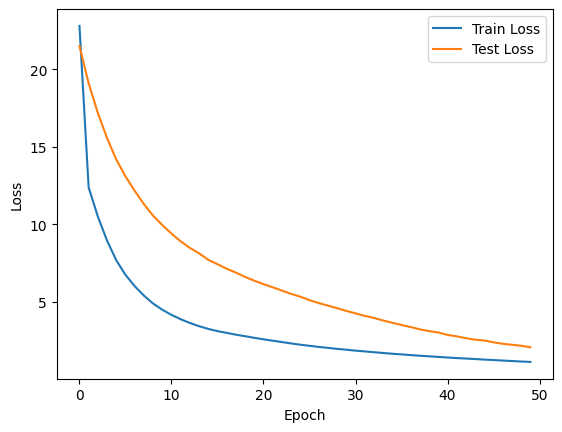

In [57]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(32, input_shape=(1, 20)))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model and track loss history
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Plot the train and test loss over epochs
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [58]:
# Make predictions
y_pred_LSTM = model.predict(X_test)

# Reshape the predictions
y_pred_LSTM = y_pred_LSTM.reshape(y_pred_LSTM.shape[0])

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((y_pred_LSTM - y_test) ** 2))
print("RMSE:", rmse)
print("SMAPE: %.8f" % smape(y_test, y_pred_LSTM))

333/333 [==============================] - 1s 787us/step
RMSE: 1.4294631994972218
SMAPE: 3.05179091
